In [1]:
import pandas_datareader.data as web
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
sns.set_theme()


Set start and end time. It is one year by default

In [2]:
end = datetime.date.today()
start = end - datetime.timedelta(365)


In [3]:
class Stock:
    def __init__(self,  label):
        self.label = label
        self.stockData = self.getStockData(label)

    def getStockData(self, label):
        stock = web.DataReader(label, 'yahoo', start, end)[
            ['Close', 'Volume']].round(2)
        addMAData(stock)
        addMAScore(stock)
        addPriceScore(stock)
        addSumScore(stock)
        addPriceDelta(stock)
        return stock


function to calculate MA and EMA, Score 

In [4]:
def caculateEMA(prices, days, smoothing=2):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) +
                   ema[-1] * (1 - (smoothing / (1 + days))))
    return [None]*(days-1)+ema


def caculateMA(prices, days):
    return prices.rolling(days).mean()


def addMAData(prices_df):
    prices_df['MA20'] = caculateMA(prices_df['Close'], 20)
    prices_df['MA60'] = caculateMA(prices_df['Close'], 60)
    prices_df['MA120'] = caculateMA(prices_df['Close'], 120)
    prices_df['EMA20'] = caculateEMA(prices_df['Close'], 20)
    prices_df['EMA60'] = caculateEMA(prices_df['Close'], 60)
    prices_df['EMA120'] = caculateEMA(prices_df['Close'], 120)


def caculateOneDayPriceScore(prices):
    score = 0
    fullScore = 120
    priceToday = prices.iloc[-1]
    price20 = prices.iloc[-20]
    price60 = prices.iloc[-60]
    price120 = prices.iloc[0]
    if priceToday['Close'] >= priceToday['EMA120']:
        score += 30
    if priceToday['Close'] >= priceToday['EMA60']:
        score += 20
    if priceToday['Close'] >= priceToday['EMA20']:
        score += 10
    if priceToday['Close'] >= price20['Close']:
        score += 30
    if priceToday['Close'] >= price60['Close']:
        score += 20
    if priceToday['Close'] >= price120['Close']:
        score += 10
    return score*100/fullScore


def addPriceDelta(pricesDF):
    pricesDeltaList = ['']
    pricesDeltaPercentageList = [0]
    for i in range(1, len(pricesDF)):
        delta = pricesDF.iloc[i]['Close']-pricesDF.iloc[i-1]['Close']
        pricesDeltaList.append(round(delta, 2))
        pricesDeltaPercentageList .append(
            str(round(delta*100/pricesDF.iloc[i-1]['Close'], 2))+'%'
        )
    pricesDF['Chg'] = pricesDeltaList
    pricesDF['%Chg'] = pricesDeltaPercentageList


def caculateOneDayMAScore(oneDayPrices):
    score = 0
    fullScore = 120
    if oneDayPrices['EMA20'] > oneDayPrices['EMA120']:
        score += 30
    if oneDayPrices['MA20'] > oneDayPrices['MA120']:
        score += 30
    if oneDayPrices['EMA20'] > oneDayPrices['EMA60']:
        score += 20
    if oneDayPrices['MA20'] > oneDayPrices['MA60']:
        score += 20
    if oneDayPrices['EMA60'] > oneDayPrices['EMA120']:
        score += 10
    if oneDayPrices['MA60'] > oneDayPrices['MA120']:
        score += 10
    return score*100/fullScore


def addMAScore(pricesDF):
    score = [None] * 119
    for i in range(119, len(pricesDF)):
        score.append(caculateOneDayMAScore(pricesDF.iloc[i, :]))
    pricesDF['MAScore'] = score


def addPriceScore(pricesDF):
    score = [None]*119
    for i in range(120, len(pricesDF)+1):
        score.append(caculateOneDayPriceScore(pricesDF.iloc[i-120:i, :]))

    pricesDF['PriceScore'] = score


def addSumScore(pricesDF):
    score = [None]*119
    for i in range(119, len(pricesDF)):
        score.append(
            (pricesDF.iloc[i]['PriceScore']+pricesDF.iloc[i]['MAScore'])/2)

    pricesDF['SumScore'] = score


Plot stock data

In [101]:

text_kw = dict(ha="center", va="center", size=20)


def plotStock(prices_df):
    prices_df['Close'].plot(figsize=(15, 7), label='Close', c='black')
    prices_df['MA20'].plot(label='MA20', c='red', linestyle='dashed')
    prices_df['EMA20'].plot(label='EMA20', c='red')
    prices_df['MA60'].plot(label='MA60', c='orange', linestyle='dashed')
    prices_df['EMA60'].plot(label='EMA60', c='orange')
    prices_df['MA120'].plot(label='MA120', c='blue', linestyle='dashed')
    prices_df['EMA120'].plot(label='EMA120', c='blue')
    prices_df['MAScore'].plot(label='MAScore', c='green')
    prices_df['PriceScore'].plot(label='PriceScore', c='yellow')
    plt.legend()


def plotSumScoreHeatMap(scoredf, ax):
    score = scoredf['SumScore'].to_numpy().reshape([1, len(scoredf)])
    sns.heatmap(score, vmin=0, vmax=100, cmap="RdYlGn", cbar=False, ax=ax, center=60, yticklabels=False,
                xticklabels=False,
                square=True, annot_kws={'rotation': 90})


def plotVolume(stockDF, ax):
    volume = stockDF.tail(20)['Volume']
    x_values = [f'{x:%Y-%m-%d}' for x in volume.index]
    ax.bar(x_values, volume.values)
    ax.axis('off')


def plotPrice(stockDF, ax):
    price = stockDF.tail(20)['Close']
    x_values = [f'{x:%Y-%m-%d}' for x in price.index]
    y = price.values
    ax.plot(x_values, y)
    x_index_max = np.argmax(y)
    x_index_min = np.argmin(y)
    ax.annotate('max', (x_index_max, y[x_index_max]), color='green')
    ax.annotate('min', (x_index_min, y[x_index_min]), color='red')
    ax.axis('off')


def plotText(text, ax, color='White'):
    kw = dict(text_kw)
    kw['backgroundcolor'] = color
    ax.text(0.5, 0.5, text, horizontalalignment='center',
            verticalalignment='center', **kw)
    ax.axis('off')


def plotStockList(stockList):
    title = ['Symbol', 'Price', 'Chg', '%Chg',
             'Price Line', 'Volume', 'Score Heat Map']
    f, ax = plt.subplots(nrows=len(stockList)+1, ncols=len(title), figsize=(20, 10), gridspec_kw={
                         'width_ratios': [2, 1, 1, 1, 3, 3, 5]})
    for i in range(len(title)):
        plotText(title[i], ax[0][i], 'Grey')
    for i in range(len(stockList)):
        color = 'Green' if stockList[i].stockData.iloc[-1]['Chg'] >= 0 else 'Red'
        plotText(stockList[i].label, ax[i+1][0])
        plotText(stockList[i].stockData.iloc[-1]['Close'], ax[i+1][1], color)
        plotText(stockList[i].stockData.iloc[-1]['Chg'], ax[i+1][2], color)
        plotText(stockList[i].stockData.iloc[-1]['%Chg'], ax[i+1][3], color)
        plotPrice(stockList[i].stockData, ax[i+1][4])
        plotVolume(stockList[i].stockData, ax[i+1][5])
        plotSumScoreHeatMap(stockList[i].stockData.tail(20), ax[i+1][-1])


In [69]:
holdingList = [Stock('GOOGL'),
               Stock('IPAY'),
               Stock('ISRG'),
               Stock('MSFT'),
               Stock('QQQ'),
               Stock('SMH'),
               Stock('TSLA'),
               Stock('VACQ'),
               Stock('XLC'),
               ]

watchList = [
    Stock('ARKK'),
    Stock('ICLN'),
    Stock('SHOP'),
    Stock('SPY'),
    Stock('U')

]


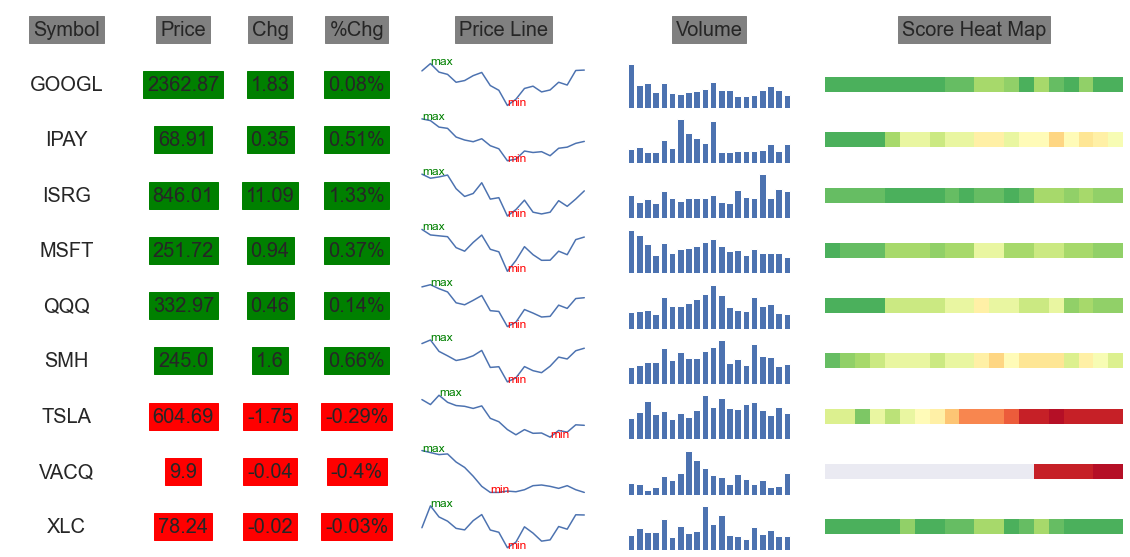

In [102]:
plotStockList(holdingList)


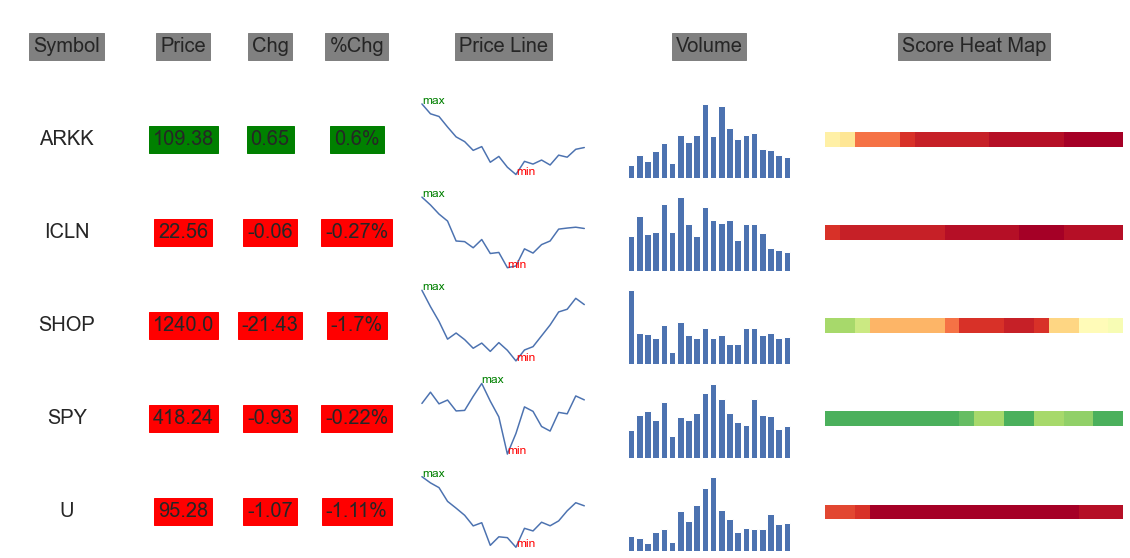

In [103]:
plotStockList(watchList)


In [66]:
watchList[0].stockData.iloc[0]['Close']
addPriceDelta(watchList[1].stockData)
volume = watchList[1].stockData.tail(20)['Volume']
close = watchList[1].stockData.tail(20)['Close']
x_values = [f'{x:%Y-%m-%d}' for x in volume.index]
close.values


array([24.04, 23.67, 23.24, 22.91, 21.97, 21.94, 21.65, 22.04, 21.38,
       21.43, 20.71, 20.79, 21.6 , 21.4 , 21.8 , 21.97, 22.53, 22.58,
       22.62, 22.56])

(-0.9500000000000001, 19.95, 20.5435, 24.2065)

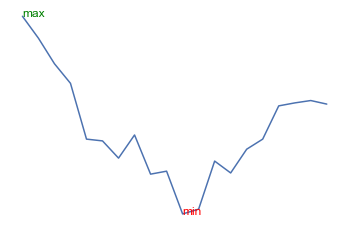

In [97]:
f, ax = plt.subplots()
y = close.values
ax.plot(x_values, y)
x_index_max = np.argmax(y)
x_index_min = np.argmin(y)
ax.annotate('max', (x_index_max, y[x_index_max]), color='green')
ax.annotate('min', (x_index_min, y[x_index_min]), color='red')
ax.axis('off')


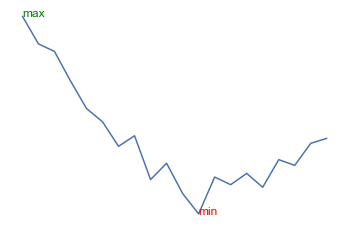

In [100]:
f, ax = plt.subplots()
plotPrice(watchList[0].stockData, ax)


In [98]:
close.values


array([24.04, 23.67, 23.24, 22.91, 21.97, 21.94, 21.65, 22.04, 21.38,
       21.43, 20.71, 20.79, 21.6 , 21.4 , 21.8 , 21.97, 22.53, 22.58,
       22.62, 22.56])